# Stocks Cluster Project

The idea behind the project is to get different stocks and then look at their movements  and then sort out the stocks into clusters based on their movements. As the stocks will now be clustered based on if they move similarly we can then identify which investment strategy would the best for each cluster.

<img src="https://www.marketplace.org/wp-content/uploads/2021/10/stockmarket.jpg?fit=2800%2C1575"/>

### Import Libraries

In [80]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math as math
import plotly.express as px

### Import Data

How to scrape the other data from this page?

Using this data from yahoo which shows the most active stocks at the moment, this means there is large amounts of liquidity in the market at the moment, so there is a greater chance of the stock being traded close to its actual value, which is what we want as we would like either a fair price for a share or a lower price

In [2]:
url ="https://uk.finance.yahoo.com/most-active/?count=25&offset=0"

In [3]:
row=[]


r = requests.get(url)
soup = BeautifulSoup(r.text,"html.parser")
table = soup.find("table",class_="W(100%)")
rows = table.find_all("tr")
    
for i in rows[1:]:
    data = i.find_all("td")
    r = [tr.text for tr in data]
    row.append(r)


In [4]:
headers = table.find_all("th")

In [5]:
titles = []

for i in headers:
    data = i.text
    titles.append(data)

In [6]:
titles

['Symbol',
 'Name',
 'Price (intraday)',
 'Change',
 '% change',
 'Volume',
 'Avg vol (3-month)',
 'Market cap',
 'PE ratio (TTM)',
 '52-week range']

In [7]:
df = pd.DataFrame(data=row,columns=titles)

In [8]:
df.head()

,Symbol,Name,Price (intraday),Change,% change,Volume,Avg vol (3-month),Market cap,PE ratio (TTM),52-week range
0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00%,450M,15.398M,2.173M,N/A,
1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90%,323.652M,110.186M,20.081M,N/A,
2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69%,356.554M,412.71M,2.315M,N/A,
3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22%,290.487M,85.753M,9.785M,N/A,
4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00%,193.223M,1.347M,30.574M,N/A,


### Data Cleaning and wrangling 

Drop the PE ratio (TTM) and 52-week range column as no usefull data in them

In [9]:
stocks = df.drop(axis=1,columns=["PE ratio (TTM)", "52-week range"])

In [10]:
stocks.head()

,Symbol,Name,Price (intraday),Change,% change,Volume,Avg vol (3-month),Market cap
0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00%,450M,15.398M,2.173M
1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90%,323.652M,110.186M,20.081M
2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69%,356.554M,412.71M,2.315M
3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22%,290.487M,85.753M,9.785M
4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00%,193.223M,1.347M,30.574M


Check to see the datatypes of the each feature and change accordingly if needed, also need to remove the % sign and the M, also need to adjust the names of the columns accordingly

In [11]:
stocks.dtypes

Symbol               object
Name                 object
Price (intraday)     object
Change               object
% change             object
Volume               object
Avg vol (3-month)    object
Market cap           object
dtype: object

In [12]:
stocks =stocks.rename(columns={"Price (intraday)" : "Price(intraday) $","Volume" : "Volume(M)","Avg vol (3-month)" : "Avg vol (3-month) (M)","Market cap" : "Market cap (M)" })

In [13]:
stocks.head()

,Symbol,Name,Price(intraday) $,Change,% change,Volume(M),Avg vol (3-month) (M),Market cap (M)
0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00%,450M,15.398M,2.173M
1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90%,323.652M,110.186M,20.081M
2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69%,356.554M,412.71M,2.315M
3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22%,290.487M,85.753M,9.785M
4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00%,193.223M,1.347M,30.574M


In [14]:
stocks["Price(intraday) $"]= stocks["Price(intraday) $"].astype(str).astype(float)
stocks["Change"]=stocks["Change"].astype(str).astype(float)
stocks["% change"]=stocks["% change"].astype(str).str.replace("%","").astype(float)

Have to convert the volume columns in a different way, first convert it into strings then remove all the integer values

In [15]:
stocks["Volume(M)"]=stocks["Volume(M)"].astype(str).str.replace("M","")
stocks["Avg vol (3-month) (M)"] = stocks["Avg vol (3-month) (M)"].astype(str).str.replace("M","")
stocks["Market cap (M)"] = stocks["Market cap (M)"].str.replace("M","")

In [16]:
def convert_to_float(value):
    value_without_M = value.replace("M", "")
    return pd.to_numeric(value_without_M, errors="coerce")

In [17]:
stocks["Volume(M)"]=convert_to_float(stocks["Volume(M)"])

In [18]:
stocks["Avg vol (3-month) (M)"]=convert_to_float(stocks["Avg vol (3-month) (M)"])

In [19]:
stocks["Market cap (M)"]=convert_to_float(stocks["Market cap (M)"])

In [20]:
stocks.head()

,Symbol,Name,Price(intraday) $,Change,% change,Volume(M),Avg vol (3-month) (M),Market cap (M)
0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00,450.000,15.398,2.173
1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90,323.652,110.186,20.081
2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69,356.554,412.710,2.315
3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22,290.487,85.753,9.785
4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00,193.223,1.347,30.574


In [21]:
stocks.dtypes

Symbol                    object
Name                      object
Price(intraday) $        float64
Change                   float64
% change                 float64
Volume(M)                float64
Avg vol (3-month) (M)    float64
Market cap (M)           float64
dtype: object

In [22]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Symbol                 25 non-null     object 
 1   Name                   25 non-null     object 
 2   Price(intraday) $      25 non-null     float64
 3   Change                 25 non-null     float64
 4   % change               25 non-null     float64
 5   Volume(M)              25 non-null     float64
 6   Avg vol (3-month) (M)  16 non-null     float64
 7   Market cap (M)         17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.7+ KB


We can see there are null data in the Volume,Avg vol and Market cap columns , for this the best thing would be to drop the data as it will vastly inaccurate to calcuate means or medians for the whole colum and apply it to the null values

In [23]:
stocks = stocks.dropna()

In [24]:
stocks = stocks.reset_index()

In [25]:
s = stocks.shape

f"The dataframe now has {s[0]} rows and {s[1]} columns "

'The dataframe now has 15 rows and 9 columns '

In [26]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  15 non-null     int64  
 1   Symbol                 15 non-null     object 
 2   Name                   15 non-null     object 
 3   Price(intraday) $      15 non-null     float64
 4   Change                 15 non-null     float64
 5   % change               15 non-null     float64
 6   Volume(M)              15 non-null     float64
 7   Avg vol (3-month) (M)  15 non-null     float64
 8   Market cap (M)         15 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ KB


There are no more null values.

Even though there isn't many stocks, this list is the most active stocks at the moment so the list is consistently changing, also when dealing with stocks (from my experience) it's best to deal with a smaller number of them so you can analyse each one in more detail

### Feature Engineering 

Volume ratio is a great way to if the current trading volume is greater than avg, if it is it will be greater than 1, however it's also a great way to see the reason behind the surge in volume, if it is greater than 1 then it can be a 1 time demand or supply side shock causing people to become more interested in the stock, so you can trade these stocks to gain something in the short term, however if the ratio is relatively low less than 1 or even below 0.5, it shows the stock is somewhat stable and that it's an external shock doesn't effect it as much, so these stocks may be good places to hold money or potential long term investments.

In [27]:
stocks["Volume_ratio"] = stocks["Volume(M)"]/stocks["Avg vol (3-month) (M)"]

In [28]:
stocks.tail()

,index,Symbol,Name,Price(intraday) $,Change,% change,Volume(M),Avg vol (3-month) (M),Market cap (M),Volume_ratio
10,13,SYME.L,Supply@ME Capital plc,0.1208,0.0008,0.67,49.046,248.180,77.778,0.197623
11,15,TRP.L,Tower Resources plc,0.0377,0.0007,1.89,39.412,161.840,3.183,0.243524
12,17,LOGP.L,Lansdowne Oil & Gas plc,0.0950,-0.0050,-5.00,36.000,5.284,1.101,6.813020
13,20,UFO.L,Alien Metals Ltd,0.1699,-0.0121,-6.65,34.568,24.870,16.842,1.389948
14,24,SCIR.L,Scirocco Energy Plc,0.5500,0.0000,0.00,25.650,1.381,4.953,18.573497


In [29]:
stocks = stocks.reset_index(drop=True)

In [30]:
stocks.head()

,index,Symbol,Name,Price(intraday) $,Change,% change,Volume(M),Avg vol (3-month) (M),Market cap (M),Volume_ratio
0,0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00,450.000,15.398,2.173,29.224575
1,1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90,323.652,110.186,20.081,2.937324
2,2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69,356.554,412.710,2.315,0.863934
3,3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22,290.487,85.753,9.785,3.387485
4,4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00,193.223,1.347,30.574,143.446919


### Data Visualisation

For stocks the most impactful factors would be the type of company they are, this can be seen from their market volume or market value . Investment strategies would depend on how much a stock fluctuates, this can be seen from the change and more importantly the % change as this will give a more scaled look at stock fluctuations. 


In [31]:
stocks_copy = stocks.copy()

In [32]:
stocks_copy=stocks_copy.drop(["index","Symbol","Name"],axis=1)

<AxesSubplot:>

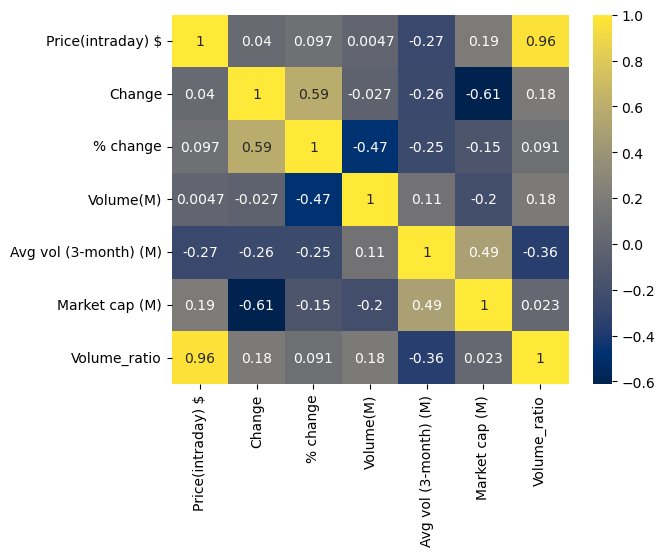

In [33]:
sns.heatmap(stocks_copy.corr(),annot=True,cmap="cividis")

##### Notable takeaways
* Price and change seem to be very closely correlated (makes sense as the change is relative, so if a company trades at a higher price then any change in their share price would be noticeably bigger than a much smaller company)

* Same reasoning above can be applied to the close relationship between volume and avg volume 

* Overall a combination of many factors will relate towards the price of a stock, macro factors such as the current economic climate of the market the company exists in and micro factors such as the activities of the company are factors that effect the price a stock trades at

* So the best thing to do in this case would be to just categorise similar stocks to one another and find relations ways to invest via these similarities 


#### Also want to have a look at the split of the companies based upon their volume ratios to see how many of these stocks are potential long term investments 

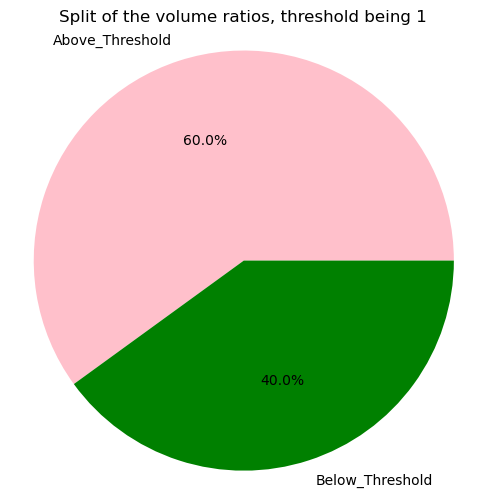

In [34]:

above_threshold = len(stocks[stocks["Volume_ratio"] >= 1])
below_threshold = len(stocks[stocks["Volume_ratio"] < 1])

data = [above_threshold,below_threshold]
labels = ["Above_Threshold","Below_Threshold"]
colors=["pink","green"]

plt.figure(figsize=(6,6))
plt.pie(data,labels=labels,colors=colors,autopct="%1.1f%%")
plt.title("Split of the volume ratios, threshold being 1")
plt.axis("equal") 
plt.show()

From the pi chart about 2/3 of the data is below the threshold indicating that the current volume isn't a one off so incident so it may be good for long term investment opportunities, likewsise 1/3 of the data indicates the current volume is a one off event so may either stay away from these stocks or try to get a small gain in some short term trades  

### Scaling the data 

Need to scale the data as the clustering model is a distance based model so any values too large or too small will cause errors when training the model 

In [35]:
scaler=StandardScaler()
scaler.fit(stocks_copy)
stocks_modif=scaler.transform(stocks_copy)
stocks_modif

array([[-4.01205314e-01, -8.12649932e-04, -1.12426660e+00,
         2.23990563e+00, -8.55262089e-01, -5.99758256e-01,
         4.25807462e-01],
       [-1.69360264e-01, -1.39044403e+00, -1.10365550e+00,
         1.30628013e+00, -6.79076711e-02, -1.47759110e-02,
        -3.15547970e-01],
       [-4.95782823e-01,  5.72105552e-01, -1.06037220e+00,
         1.54940345e+00,  2.44500122e+00, -5.95119687e-01,
        -3.74021921e-01],
       [-4.25326917e-01,  3.16120823e-01, -5.51278122e-01,
         1.06121341e+00, -2.70859843e-01, -3.51104827e-01,
        -3.02852493e-01],
       [ 3.62050804e+00,  6.08674799e-01,  5.24621104e-01,
         3.42498814e-01, -9.71976409e-01,  3.27988203e-01,
         3.64711642e+00],
       [-4.66455118e-01,  7.79331285e-01,  2.08488109e+00,
        -2.55718175e-01, -4.68703531e-01, -5.59219777e-01,
        -3.47266350e-01],
       [-4.57778283e-01,  7.79331285e-01,  1.75304244e+00,
        -3.70954584e-01, -5.57250585e-01, -5.97798298e-01,
        -3.4521601

### Choosing K

Create an elbow curve to find best value for K, do this by seeing at which no.of clusters the inertias stop changing by a significant amount

C:\ana\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


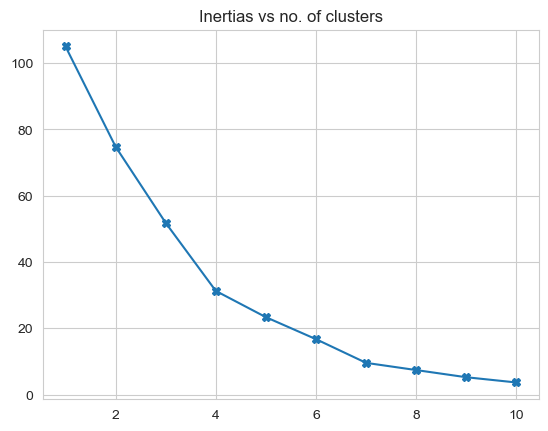

In [36]:
sns.set_style(style="whitegrid")
inertias=[]

for i in range(1,11):
    model=KMeans(n_clusters=i,init="k-means++",random_state=50)
    clusters=model.fit_predict(stocks_modif)
    inertias.append(model.inertia_)
    
plt.plot(range(1,11),inertias,marker="X")
plt.title("Inertias vs no. of clusters")
plt.show()


To gain a more clearer view on when the inertias stop changing by a significant amount, could look a the % change of inertias 

In [37]:
percentages = []

for i in range(12):
    model1 = KMeans(n_clusters=i+1,init="k-means++",random_state=0)
    model2 = KMeans(n_clusters=i+2,init="k-means++",random_state=0)
    clusters1=model1.fit_predict(stocks_modif)
    clusters2=model2.fit_predict(stocks_modif)
    inertia1=model1.inertia_
    inertia2=model2.inertia_
    percent =(inertia1 - inertia2)/inertia1 *100
    percentages.append(percent)
    

C:\ana\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


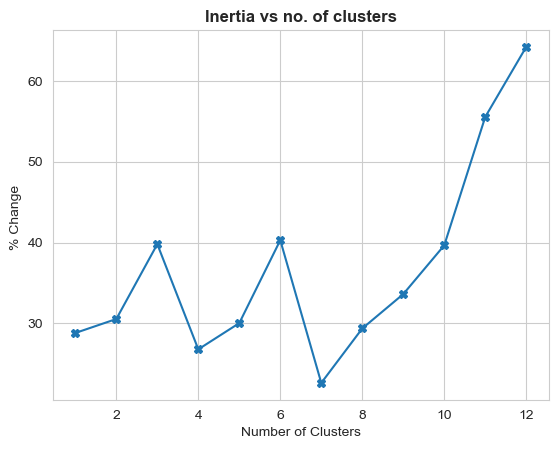

In [38]:
plt.plot(range(1,13),percentages,marker="X")
plt.title("Inertia vs no. of clusters", weight="bold")
plt.ylabel("% Change ")
plt.xlabel("Number of Clusters")
plt.show()

From this the best number of clusters is between 5 or 6, in this case I would go with 6 as we want accurate clusters

##### Potential issue : as the data we scrape changes in livetime the most optimal number of clusters may vary every time, which may cause inaccurate clusters to form

To solve this need to automate the process, to do this we need to :
* Form a line from the start and end point of the elbow curve 
* Then find the X values (number of clusters) where the distance from the line and the elbow curve is at its maximum, this is because the elbow curve, at the maximum no of clusters, turns and starts upwards closer to the line and at the beginning it moves away from the line

In [39]:
inertias =[]

for k in range(13):
    model = KMeans(n_clusters=k+1)
    model.fit(stocks_modif)
    inertias.append(model.inertia_)

C:\ana\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [40]:
inertias

[105.00000000000001,
 81.07811251303173,
 51.93484222248789,
 31.26361756810164,
 22.892507711744898,
 16.01940709229991,
 9.565041542115488,
 7.438861857693954,
 5.640877553756288,
 3.4711900515913934,
 2.094710212347355,
 0.931088349462061,
 0.333107706544998]

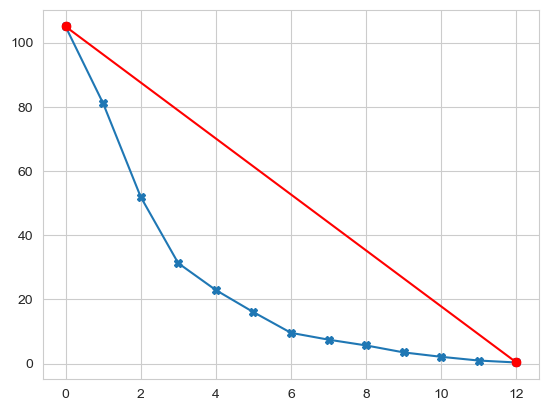

In [41]:
K=range(13)
plt.plot(K,inertias,marker="X")
plt.plot([K[0],K[12]],[[inertias[0]],[inertias[12]]],"ro-")
plt.show()

#### Function to find distance



In [42]:
def distance(x1,y1,a,b,c):
    d=abs(a*x1+b*y1+c)/math.sqrt(a**2+b**2)
    return d 

a=inertias[0]-inertias[12]
b=K[8]-K[0]
c1=K[0]*inertias[12]
c2=K[12]*inertias[0]
c=c1-c2

In [43]:
K=range(13)
distances=[]
for k in range(13):
    dist = distance(K[k],inertias[k],a,b,c)
    distances.append(dist)
distances

[4.00106013244116,
 4.827071448138682,
 6.051007841390489,
 6.629283967307968,
 6.270160113361725,
 5.796871973018601,
 5.291671752834079,
 4.456617591443858,
 3.5965514404821053,
 2.7648130389970733,
 1.8726237507147176,
 0.9642124136117709,
 0.012693180613962138]

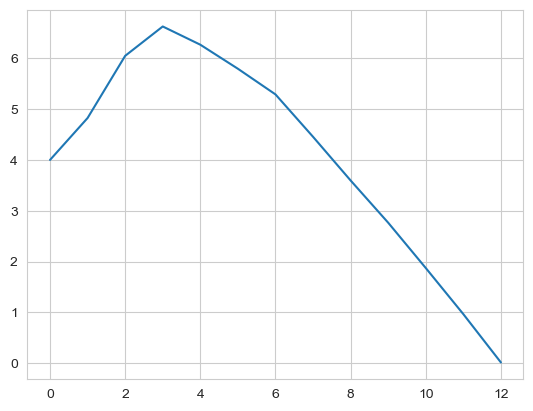

In [44]:
plt.plot(K,distances)

In [45]:
max_k=distances.index(max(distances))+1
max_k

4

### Clustering Implementation

Implementing the model with the number of clusters we want, and then making sure to add 1 to the clusters array before we add it to the dataframe

In [46]:
model = KMeans (n_clusters=max_k,random_state=50)

clusters = model.fit_predict(stocks_modif)
clusters

array([0, 0, 0, 0, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [47]:
stocks["Cluster"]=clusters+1

In [48]:
stocks

,index,Symbol,Name,Price(intraday) $,Change,% change,Volume(M),Avg vol (3-month) (M),Market cap (M),Volume_ratio,Cluster
0,0,KIBO.L,Kibo Mining Plc,0.0575,-0.0050,-8.00,450.000,15.398,2.173,29.224575,1
1,1,BCE.L,Beacon Energy plc,0.1911,-0.0164,-7.90,323.652,110.186,20.081,2.937324,1
2,2,ICON.L,Iconic Labs Plc,0.0030,-0.0003,-7.69,356.554,412.710,2.315,0.863934,1
3,3,UKOG.L,UK Oil & Gas Investments PLC,0.0436,-0.0024,-5.22,290.487,85.753,9.785,3.387485,1
4,4,BBSN.L,Brave Bison Group plc,2.3750,0.0000,0.00,193.223,1.347,30.574,143.446919,4
5,5,VELA.L,Vela Technologies PLC,0.0199,0.0014,7.57,112.266,61.935,3.414,1.812642,2
6,6,MSMN.L,Mosman Oil And Gas Limited,0.0249,0.0014,5.96,96.671,51.275,2.233,1.885344,2
7,8,PREM.L,Premier African Minerals Limited,0.4005,-0.0295,-6.86,80.047,321.665,110.307,0.248852,3
8,11,BOIL.L,Baron Oil Plc,0.0914,-0.0036,-3.79,62.914,165.801,19.177,0.379455,2
9,12,RRR.L,Red Rock Resources plc,0.1501,-0.0049,-3.16,52.597,107.794,4.084,0.487940,2


### Clustering Evaluation

It will be hard to strictly assume that each group will have a set characteristics due to the nature of the data, however we can create visuals to help understand each cluster regardless of the number of clusters formed

In [86]:

display(px.scatter(stocks, "Cluster" , "index" ,"Name",title="Clusters"))

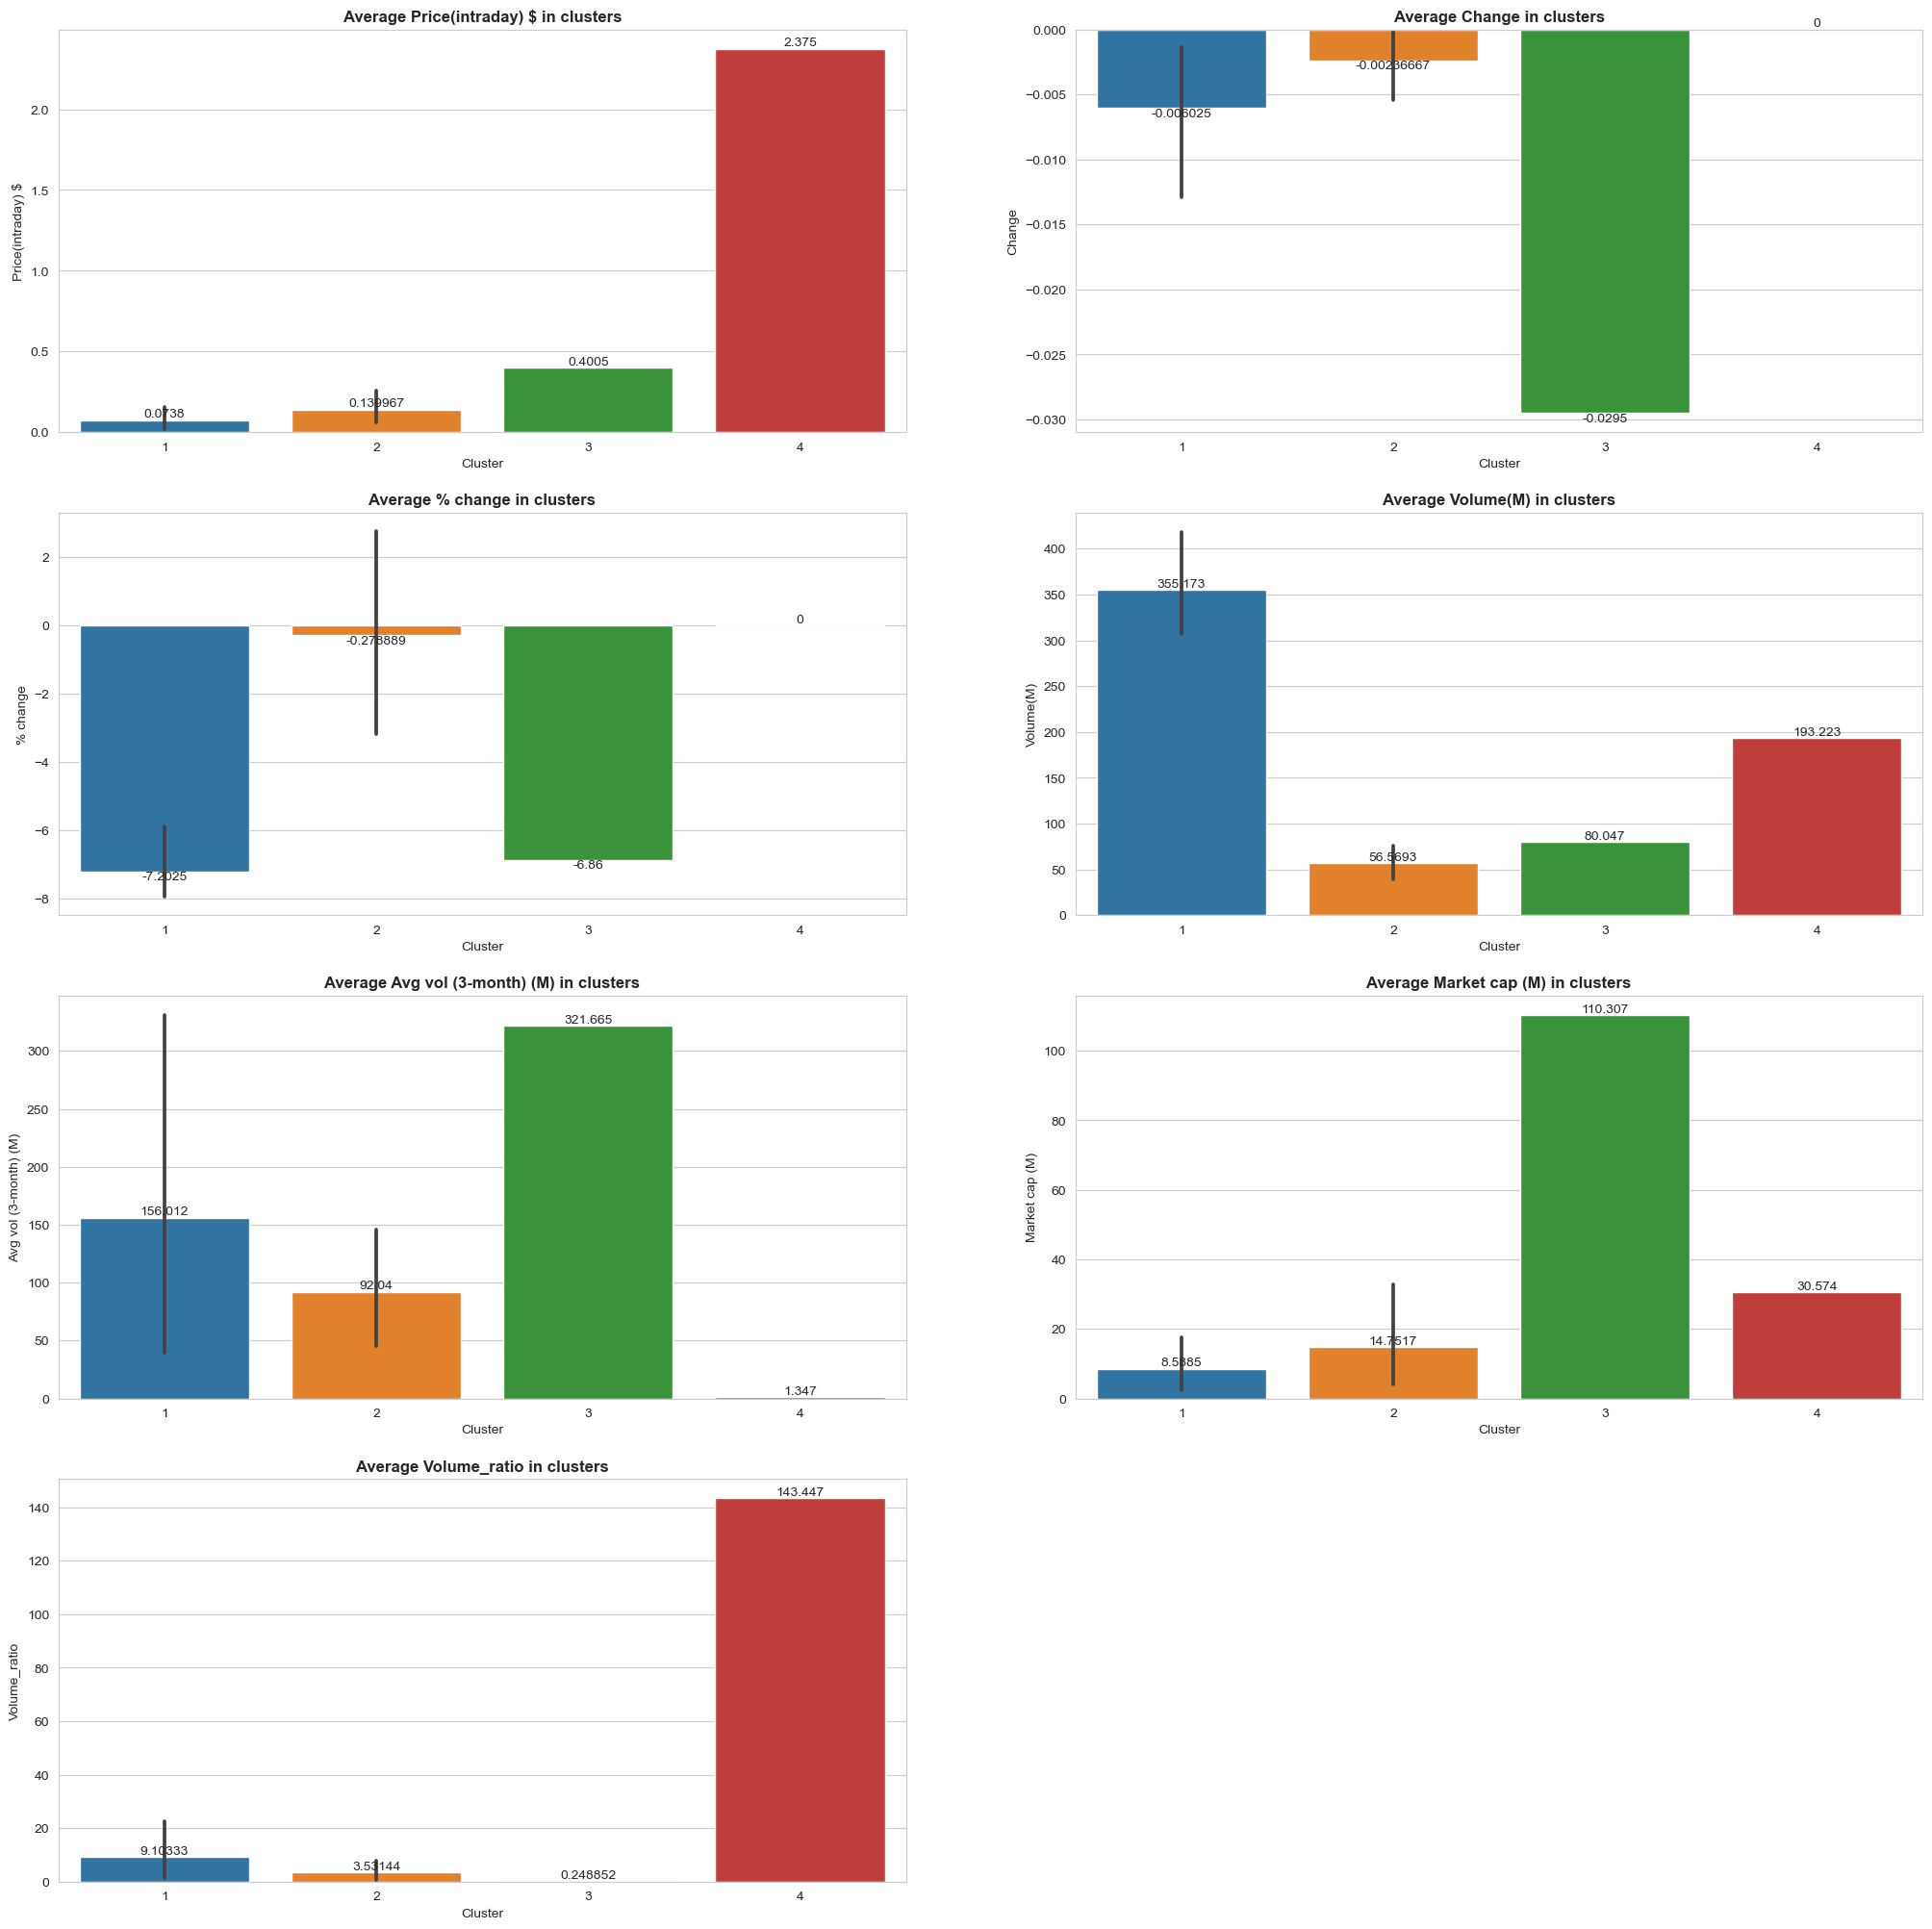

In [56]:
stocks_anal=stocks.drop(["index","Symbol","Name","Cluster"],axis=1)

plt.figure(figsize=(25,25))
for i,col in enumerate(stocks_anal):
    plt.subplot(4,2,i+1)
    p=sns.barplot(data=stocks,x="Cluster",y=col)
    plt.title(f"Average {col} in clusters" ,weight="bold")
    p.bar_label(p.containers[0])
    
plt.show()

#### Takeaways - this will change due to the nature of the data
* Cluster 1 looks to be smaller companies due to have the lowest market cap and price
* Cluster 2 are relatively small companies as well but have lower volume and change compared to cluster 1 
* Cluster 3 tends to be more medium to large size companies that change as much as cluster 1 but their volume ratio is incredibly low indicating the current change is likely not  to do with 1 time events 
* Cluster 4 are the medium size companies bigger than 1 and 2 but smaller than 3 in terms of market cap, don't change as much as the others but volume ratio is the highest indicating the current change is likely to do with 1 time events 


### Conclusion and Recommendations

###### Personally for me I try to emulate Warren Buffets investing style of long term durable stocks, that show a consistent positive trend over time, for this I would need to find companies that are :
* Not largely effected by 1 time events (Volume ratio should be somewhat low)
* The % change is not exceptionally high, unless it's a company that I know has good economics, in this case if the %change is negative so the price falls potential buying oppurtunity in a bear market
* Also a relatively high market cap, is ideal as it means the company has most likely has a competitive advantage hence why it was able to grow itself until it possessed a high market cap

#### From what I've said above from the current data, the best stocks that would fit what I'm looking for is in cluster 3 

### Potential improvements 
* More data would make the model more accurate naturally 
* A way to access the balance sheets, cash flows and income statements of the company and scrape it and use it in analytics (I wasn't able to find a summarised version for multiple companies online, I would've had to manually do it, which isn't efficient)